# DEMETER Satellite - IAP Sensor Data Processing

Notations used:
- H-ion density: $n_{\mathrm{H}}$
- O-ion density: $n_{\mathrm{O}}$
- magnetic latitude: $\Phi_{\mathrm{m}}$

## Calculating correction terms for $\mathrm{H}^{+}$ ion data

### Initialization

Loading in necessary libraries:

In [1]:
import demeter_process.process_data as pr
import demeter_process.read_data as rd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.stats import binned_statistic_2d
from os import listdir

params = {'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

mpl.rcParams.update(params)

%matplotlib inline

Loading data files.

In [2]:
data_dir = '/home/istvan/demeter/IAP_data/1140/'
input_paths = [data_dir + path for path in listdir(data_dir)]

In [3]:
# required fields: CNES Julian day, H+ ion and O+ densities, magnetic latitude and longitude
req = ['cnesjd', 'h', 'o', 'mlat', 'mlon']

# Loading only day data
day, _ = rd.read_data(input_paths, required=req, corr_lon=True)

In [18]:
idx_frac, idx_whole = rd.read_idx('/home/istvan/work/demeter/geomag_indices/idx')

In [4]:
# filtering out low ion densities and restricitng mag. lat. values
day = day[(day['h']  < 1.4e4) & (day['h'] > 100) & (np.abs(day['mlat']) < 60)]

Binning data for $\Phi_{\mathrm{m}}$ values and CNES Julian day values. In each case mean $n_{\mathrm{H}}$ values are calulated in each bin.

In [5]:
# bin number for H-ion densities
ion_bins = 1e3

# bin number for Phi_m
mlat_bins = 30

# bin number for CNES Jd.
cnesjd_bins = 100;

# calculating mean values and standard deviations
calc_stat = {'mean': 'mean', 'std': np.std}

Calculating mean values and std values in each bin.

In [6]:
binned_mlat_h_log = pr.calc_statitistic(day['mlat'], np.log10(day['h']), statistics=calc_stat, bins=mlat_bins)

binned_cnesjd_h = pr.calc_statitistic(day['cnesjd'], day['h'], statistics=calc_stat, bins=cnesjd_bins)

#cnesjd_ap = pr.calc_statitistic(idx_whole['cnesjd'], idx_whole['ap'], statistics=calc_stat, bins=200)

Plotting 2D histogram of $\Phi_{\mathrm{m}}$ and $\log_{10}(n_{\mathrm{H}})$ value pairs and the binned $\log_{10}(n_{\mathrm{H}})$ mean values.

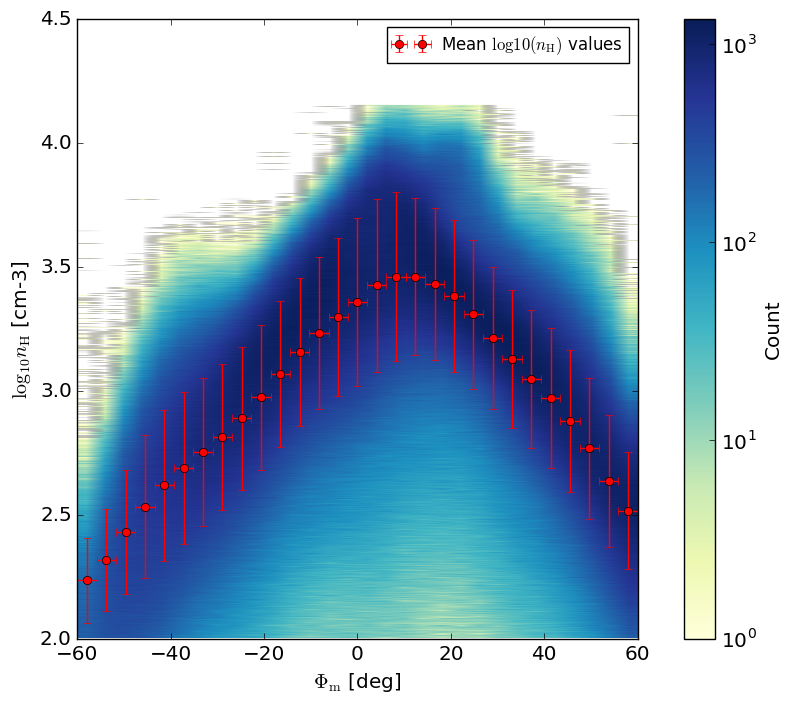

In [9]:
# plotting 2d histogram and H+ ion median values in bins
plt.figure(figsize=(12,8), dpi=100)

# if we have not calculated the histogram values yet
if 'hist2_mlat_h_log' not in locals():
    hist2_mlat_h_log = np.histogram2d(day['mlat'], np.log10(day['h']), bins=[mlat_bins, ion_bins])

pr.plot_hist2(hist2_mlat_h_log,
              axis_labels=[r'$\Phi_{\mathrm{m}}$ [deg]', r'$\log_{10}n_{\mathrm{H}}$ [cm-3]'], lognorm=True)

pr.plot_statistic(binned_mlat_h_log, err_bar=binned_mlat_h_log['std'],
                  label=r'Mean $\log{10}(n_{\mathrm{H}})$ values')
plt.legend();

The relationship between $\Phi_{\mathrm{m}}$ and $n_{\mathrm{H}}$ may be modelled by a polynomial.

Plotting 2D histogram of CNES Jd. and $n_{\mathrm{H}}$ value pairs and the binned $n_{\mathrm{H}}$ mean values.

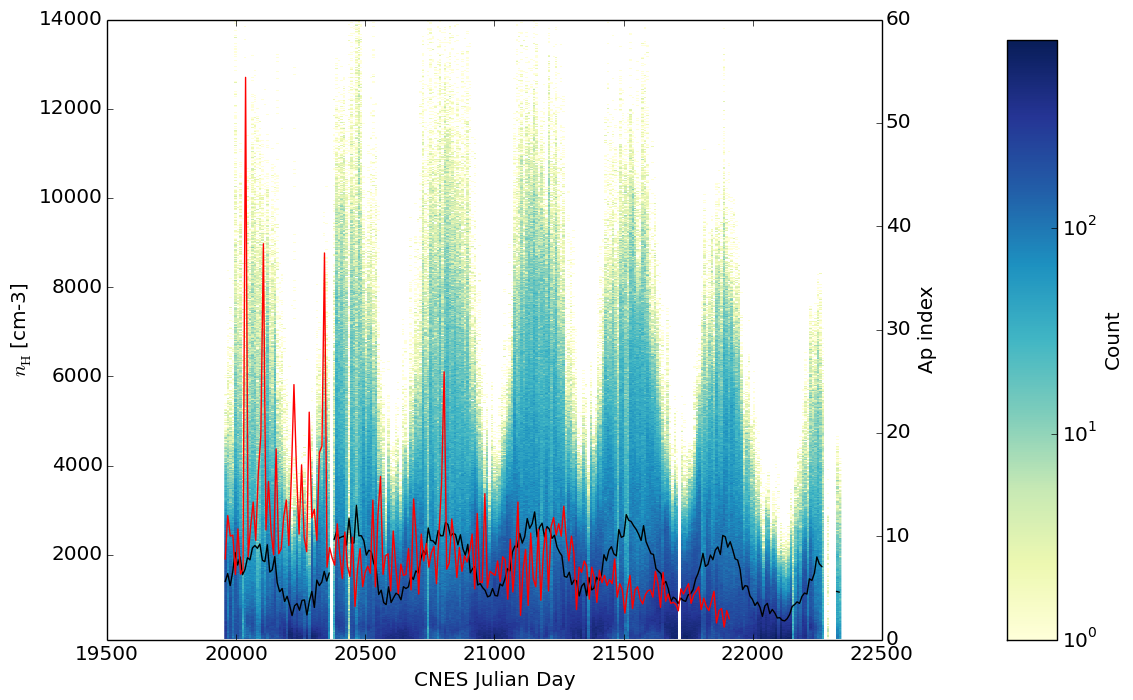

In [44]:
from matplotlib.colors import LogNorm

# plotting 2d histogram and H+ ion median values in bins
fig, ax1 = plt.subplots(figsize=(10,8), dpi=100)

ax1.set_xlabel('CNES Julian Day')
ax1.set_ylabel(r'$n_{\mathrm{H}}$ [cm-3]')

_, _, _, im = ax1.hist2d(day['cnesjd'], day['h'], bins=[cnesjd_binnum, h_binnum], cmap='YlGnBu', norm=LogNorm())

cax = fig.add_axes([1.025, 0.125, 0.05, 0.75])

cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Count')

ax2 = ax1.twinx()

ax1.plot(cnesjd_h['bins'][:-1] + cnesjd_h['half_bin'], cnesjd_h['mean'], 'k-',label='Mean H-ion values')
ax2.plot(cnesjd_ap['bins'][:-1] + cnesjd_ap['half_bin'], cnesjd_ap['mean'], 'r-', label='Ap index')

ax2.set_ylabel('Ap index');

#plt.legend(handles=[label1, label2]);

### Calculating corrections

Now I will fit a polynom to the $\mathrm{log}_{10} n_{\mathrm{H}}$ values.

In [10]:
# fitting 4th order polynom to the log10 n_H values
z, V = np.polyfit(pr.get_bin_centers(binned_mlat_h_log), binned_mlat_h_log['mean'], 4, cov=True)
p = np.poly1d(z)

# we will evaluate the polynom at mlat values
mlat = np.arange(binned_mlat_h_log['bins'][0], binned_mlat_h_log['bins'][-1], 1)

In [11]:
print('Polynom coefficients from highest to lowest order: ', z)

('Polynom coefficients from highest to lowest order: ', array([  3.23026569e-08,  -2.08453126e-06,  -3.94367851e-04,
         8.77047007e-03,   3.35329833e+00]))


In [12]:
# saving coefficients to a file
np.save('/home/istvan/demeter/corrections/mlat_h_poly', z)

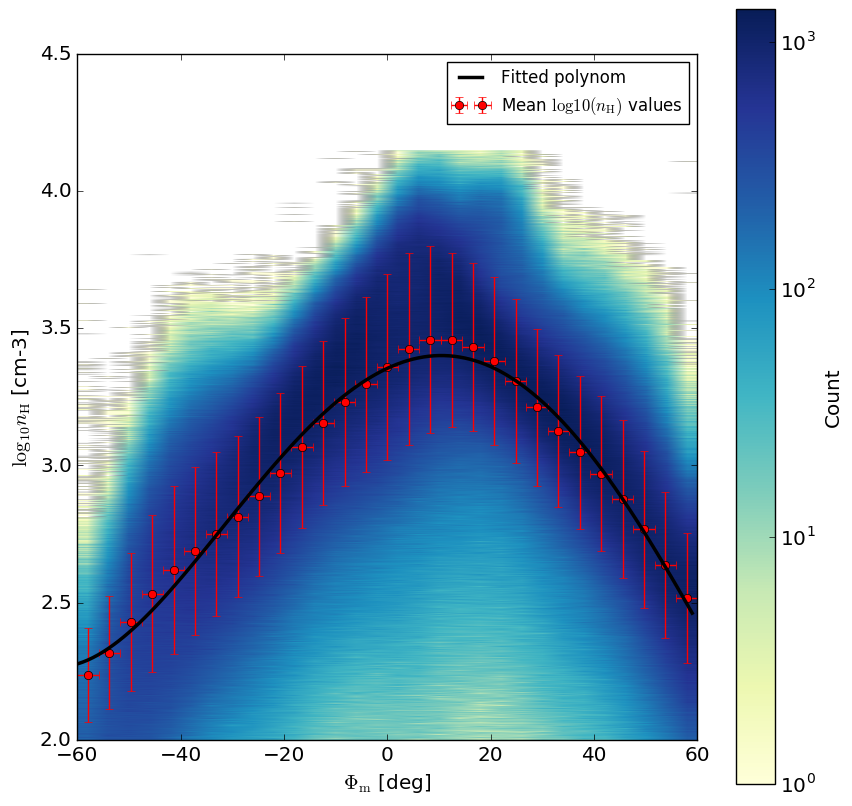

In [13]:
plt.figure(figsize=(10,10), dpi=100)

if 'hist2_mlat_h_log' not in locals():
    hist2_mlat_h_log = np.histogram2d(day['mlat'], np.log10(day['h']), bins=[mlat_bins, ion_bins])

pr.plot_hist2(hist2_mlat_h_log,
              axis_labels=[r'$\Phi_{\mathrm{m}}$ [deg]', r'$\log_{10}n_{\mathrm{H}}$ [cm-3]'], lognorm=True)

pr.plot_statistic(binned_mlat_h_log, err_bar=binned_mlat_h_log['std'],
                  label=r'Mean $\log{10}(n_{\mathrm{H}})$ values')
plt.plot(mlat, p(mlat), 'k-', label='Fitted polynom', linewidth=2.5)
plt.legend();

Calculating correction values. I have to raise 10 to the power of evaluated polynom values since we fitted the polynom to $\mathrm{log}_{10} n_{\mathrm{H}}$ values.

In [14]:
mlat_corr = pr.poly_corr('corrections/mlat_h_poly.npy', day['mlat'], fun=lambda x: np.power(10, x))

In [15]:
binned_mlat_h_corr = pr.calc_statitistic(day['mlat'], day['h'] - mlat_corr, statistics=calc_stat, bins=mlat_bins)

Let's look at the histograms now with the $\Phi_{\mathrm{m}}$ corrected $n_{\mathrm{H}}$ values.

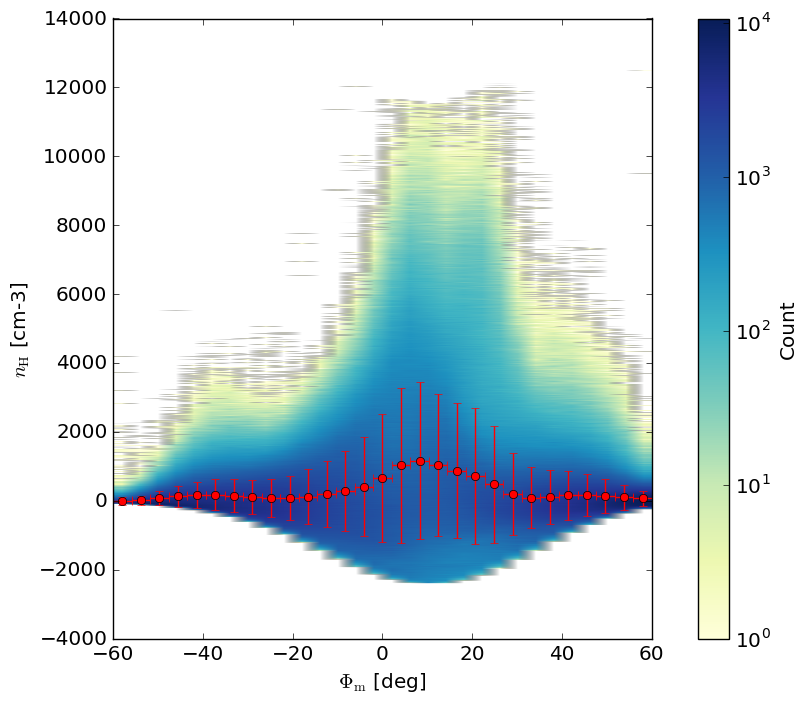

In [17]:
plt.figure(figsize=(12,8), dpi=100)

if 'hist2_mlat_h_corr' not in locals():
    hist2_mlat_h_corr = np.histogram2d(day['mlat'], day['h'] - mlat_corr, bins=[mlat_bins, ion_bins])

pr.plot_hist2(hist2_mlat_h_corr,
              axis_labels=[r'$\Phi_{\mathrm{m}}$ [deg]', r'$n_{\mathrm{H}}$ [cm-3]'], lognorm=True)
pr.plot_statistic(binned_mlat_h_corr, err_bar=binned_mlat_h_corr['std'],
                  label=r'Mean $n_{\mathrm{H}}$ values')
plt.legend();

The correction reduced standard deviance and pushed $n_{\mathrm{H}}$ values towards zero $\mathrm{cm}^{-3}$.

In [18]:
not_nan = ~np.isnan(binned_cnesjd_h['mean'])

a = np.asarray([pr.get_bin_centers(binned_cnesjd_h)[not_nan], binned_cnesjd_h['mean'][not_nan]])

np.save('/home/istvan/demeter/corrections/cnesjd_h_mean', a)

In [19]:
cnesjd_corr = pr.interpol_corr('corrections/cnesjd_h_mean.npy', day['cnesjd'])

In [21]:
binned_cnesjd_h_corr = pr.calc_statitistic(day['cnesjd'], day['h'] - cnesjd_corr,
                                           statistics=calc_stat, bins=cnesjd_bins)

Plotting histogram of $\Phi_{\mathrm{m}}$ corrected CNES Jd. and $n_{\mathrm{H}}$ values pairs.

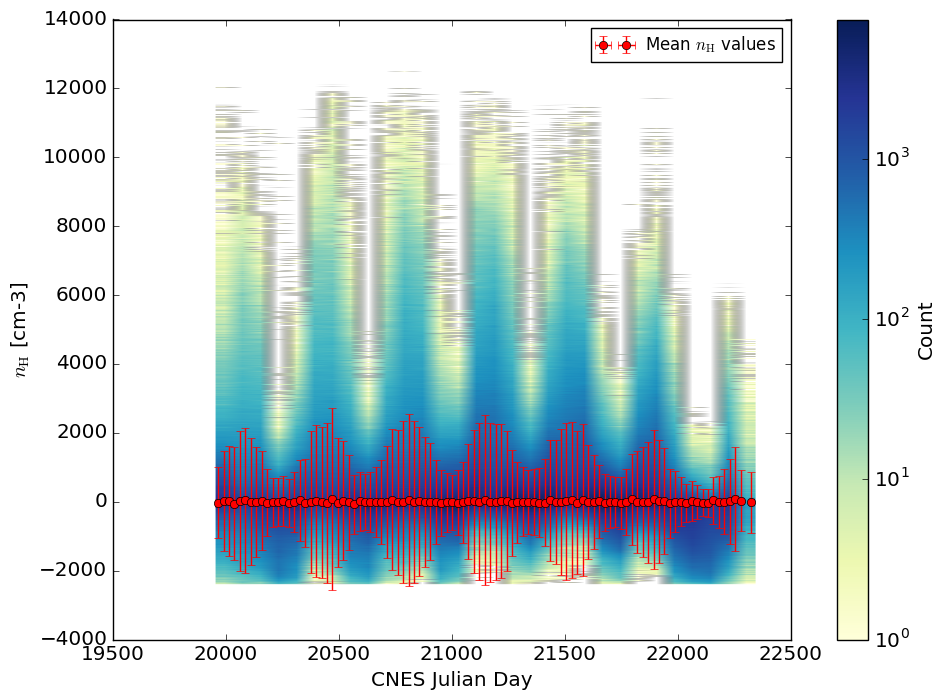

In [23]:
plt.figure(figsize=(12,8), dpi=100)

if 'hist2_cnesjd_h' not in locals():
    hist2_cnesjd_h = np.histogram2d(day['cnesjd'], day['h'] - mlat_corr, bins=[mlat_bins, ion_bins])

pr.plot_hist2(hist2_cnesjd_h,
              axis_labels=['CNES Julian Day', r'$n_{\mathrm{H}}$ [cm-3]'], lognorm=True)
pr.plot_statistic(binned_cnesjd_h_corr, err_bar=binned_cnesjd_h_corr['std'],
                  label=r'Mean $n_{\mathrm{H}}$ values')
plt.legend();

Now I will calculate temporal correction, interpolating the CNES Jd. mean $n_{\mathrm{H}}$ values to the observed CNES Jd. time points.

Histogram of $\Phi_{\mathrm{m}}$ and temporally corrected $n_{\mathrm{H}}$ values.

In [25]:
binned_mlat_h_corr = pr.calc_statitistic(day['mlat'], day['h'] - mlat_corr - cnesjd_corr,
                                         statistics=calc_stat, bins=mlat_bins)

In [26]:
hist2_mlat_h_corr = np.histogram2d(day['mlat'], day['h'] - mlat_corr - cnesjd_corr,
                                   bins=[mlat_bins, ion_bins])


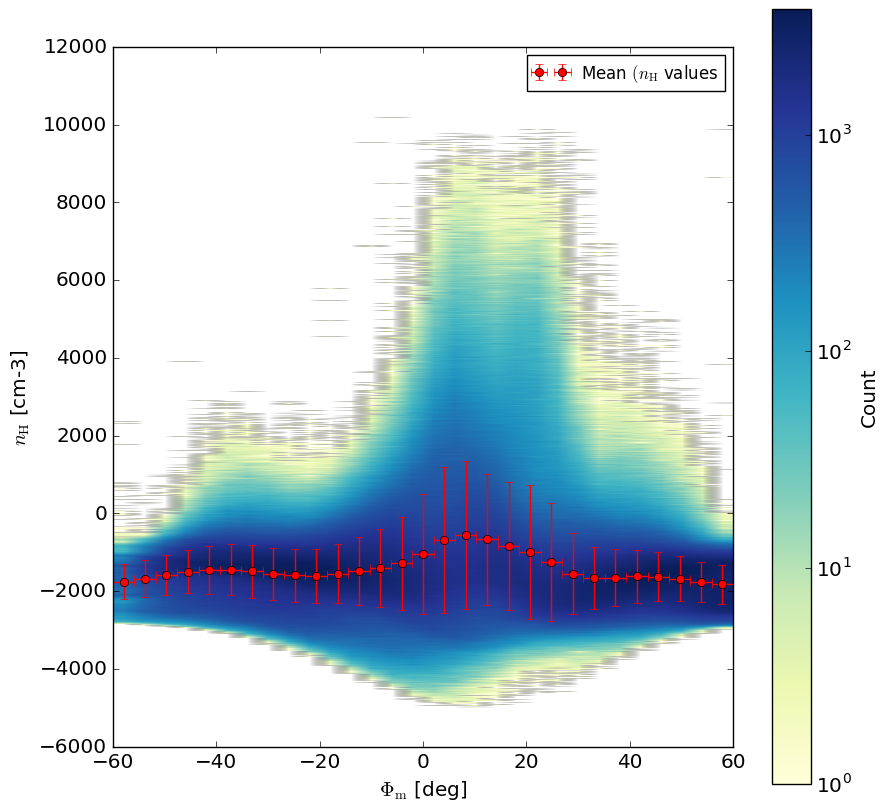

In [28]:
plt.figure(figsize=(10,10), dpi=100)

pr.plot_hist2(hist2_mlat_h_corr,
              axis_labels=[r'$\Phi_{\mathrm{m}}$ [deg]', r'$n_{\mathrm{H}}$ [cm-3]'], lognorm=True)

pr.plot_statistic(binned_mlat_h_corr, err_bar=binned_mlat_h_corr['std'],
                  label=r'Mean $n_{\mathrm{H}}$ values')
plt.legend();

Temporal correction pushed high count bins away from $0$ $\mathrm{cm}^{-3}$. But significantly reduced standard deviation.

Another significant reduction in variance. Now there are even more $n_{\mathrm{H}}$ values around $0$ $\mathrm{cm}^{-3}$.  
Finally I will plot the spatial distribution of uncorrected and corrected $n_{\mathrm{H}}$ values.

In [66]:
reload(pr)

<module 'demeter_process.process_data' from 'demeter_process/process_data.py'>

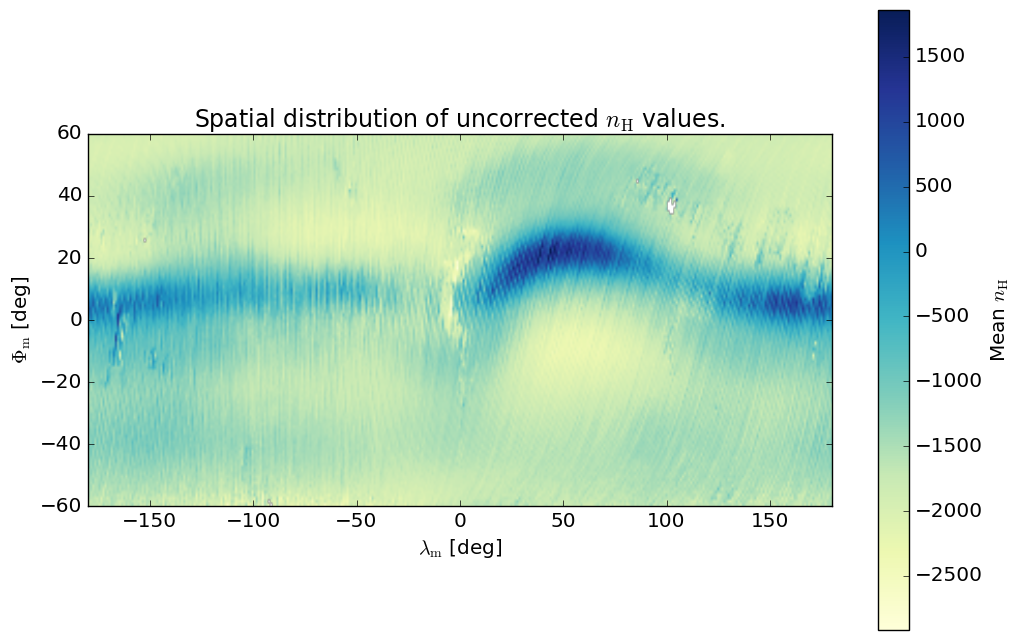

In [29]:
plt.figure(figsize=(12,8), dpi=100)

if 'binned2_mlat_h' not in locals():
    binned2_mlat_h = binned_statistic_2d(day['mlon'], day['mlat'], day['h'] - mlat_corr - cnesjd_corr,
                                               statistic='mean', bins=[360, 120])

plt.title(r'Spatial distribution of uncorrected $n_{\mathrm{H}}$ values.', size=17)

pr.plot_hist2(binned2_mlat_h, axis_labels=[r'$\lambda_{\mathrm{m}}$ [deg]', r'$\Phi_{\mathrm{m}}$ [deg]'],
             colorbar_label=r'Mean $n_{\mathrm{H}}$', aspect_ratio=0.5)

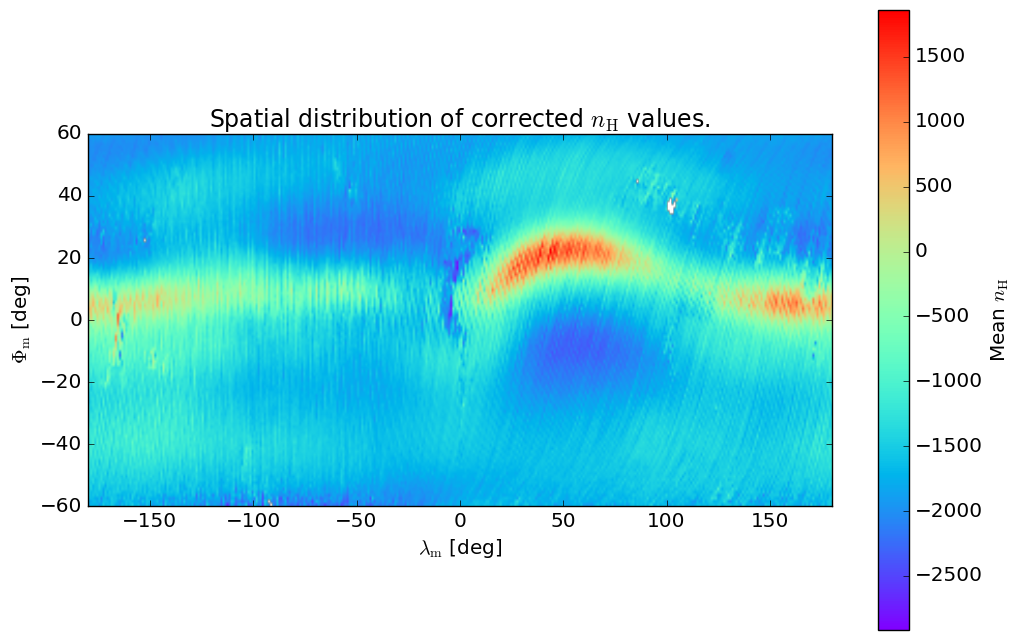

In [30]:
plt.figure(figsize=(12,8), dpi=100)

if 'binned2_mlat_h_corr' not in locals():
    binned2_mlat_h_corr = binned_statistic_2d(day['mlon'], day['mlat'], day['h'] - mlat_corr - cnesjd_corr,
                                               statistic='mean', bins=[360, 120])

plt.title(r'Spatial distribution of corrected $n_{\mathrm{H}}$ values.', size=17)

pr.plot_hist2(binned2_mlat_h_corr, axis_labels=[r'$\lambda_{\mathrm{m}}$ [deg]', r'$\Phi_{\mathrm{m}}$ [deg]'],
             colorbar_label=r'Mean $n_{\mathrm{H}}$', aspect_ratio=0.5, cmap='rainbow')